<a href="https://colab.research.google.com/github/TienLungSun/Intelligent-camera-based-motion-analysis/blob/main/2.%20MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#load data file to colab
from google.colab import files
uploaded = files.upload()

Saving raw_data_LOGGER20.csv to raw_data_LOGGER20.csv


In [2]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

raw_data_LOGGER20.csv


In [3]:
import pandas as pd
df=pd.read_csv(fname)

In [4]:
df.head(3)

,X,Y,Z
0,11.49,2.16,-3.18
1,11.53,2.20,-3.26
2,11.53,2.24,-3.30


In [5]:
df.columns

Index(['X', 'Y', 'Z'], dtype='object')

如果分析 IMU sensor, 略過下行, 不用選 SID

In [ ]:
# select a subject ID
sid = 1
df = df[ df['ID']== sid]

如果分析 IMU sensor, 從此處跑

In [6]:
#select a column
dfx = df[['X']]
dfx.shape

(758, 1)

In [7]:
dfx.head(3)

,X
0,11.49
1,11.53
2,11.53


In [8]:
#convert to list
lstX = dfx.values

In [9]:
lstY = df[['Y']].values
lstZ = df[['Z']].values

In [10]:
def time_series_of_scale (lstX, scale):
  #function to calculate time series of different scales
  result = []
  idx = 0
  N = len(lstX)
  while(idx+scale <= N): #idx from 0 to N-1
    sum = 0
    for i in range(idx, idx+scale): #i=idx, idx+1, ...,idx+scale-1
      sum = sum + lstX[i]
      idx = idx+1
    result.append(sum/scale)
  return result

In [11]:
#test time_series_of_scale
tmp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(time_series_of_scale (tmp, scale=2))
print(time_series_of_scale (tmp, scale=3))

[1.5, 3.5, 5.5, 7.5, 9.5, 11.5]
[2.0, 5.0, 8.0, 11.0]


sample entropy https://en.wikipedia.org/wiki/Sample_entropy

In [12]:
import numpy as np

In [13]:
def SampleEntropy(time_series, sample_length, tolerance):
  #function to calculate sample entropy
  N = len(time_series)
  B = 0.0
  A = 0.0
    
  # Split time series and save all templates of length m
  xmi = np.array([time_series[i : i + sample_length] for i in range(N - sample_length)])
  xmj = np.array([time_series[i : i + sample_length] for i in range(N - sample_length + 1)])

  # Save all matches minus the self-match, compute B
  B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= tolerance) - 1 for xmii in xmi])

  # Similar for computing A
  sample_length += 1
  xm = np.array([time_series[i : i + sample_length] for i in range(N - sample_length + 1)])
  A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance) - 1 for xmi in xm])

  # Return SampEn
  if(A>0 and B>0):
    return -np.log(A / B)
  else:
    print("This time series is not suitable to calculate SamE, A=", A, " B=", B)
    return -99

In [14]:
def MSE(lst, sample_length, maxScale):
  MSE = []
  for scale in range(1, maxScale+1):
    time_series = time_series_of_scale(lst, scale)
    time_series = np.array(time_series)
    tolerance = 0.1 * np.std(time_series, ddof=1)
    sampen = SampleEntropy(time_series, sample_length, tolerance)
    MSE.append(sampen)
  return MSE

In [19]:
maxScale = 10
sample_length=2
MSEResults = []
for time_series in [lstX, lstY, lstZ]:
  MSEResults.append(MSE(time_series, sample_length, maxScale))

In [34]:
print("scale", end=":")
for i in range(1, maxScale+1):
  print(i, end="      ")
for label, lst in zip(["X", "Y", "Z"], MSEResults):
  print("\n", label, end = ":  ")
  for elt in lst:
    print("%0.3f" %elt, end=", ")

scale:1      2      3      4      5      6      7      8      9      10      
 X:  0.373, 0.394, 0.380, 0.390, 0.445, 0.480, 0.594, 0.495, 0.651, 0.881, 
 Y:  0.433, 0.534, 0.538, 0.518, 0.707, 0.560, 0.505, 0.533, 0.860, 0.744, 
 Z:  0.618, 0.808, 0.725, 0.853, 0.834, 0.872, 0.882, 1.066, 0.819, 1.269, 

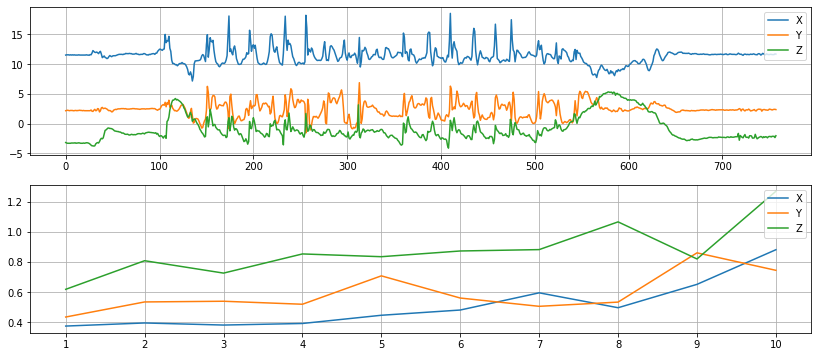

In [25]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 6))
fig.add_subplot(2, 1, 1) 
plt.plot(lstX,label = "X")
plt.plot(lstY,label = "Y")
plt.plot(lstZ,label = "Z")
plt.legend(loc='upper right')
plt.grid()

fig.add_subplot(2, 1, 2) 
plt.plot(MSEResults[0],label = "X")
plt.plot(MSEResults[1],label = "Y")
plt.plot(MSEResults[2],label = "Z")
plt.xticks(np.arange(maxScale), np.arange(1, maxScale+1))
plt.legend(loc='upper right')
plt.grid()
plt.show()